In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    "Solved",
    "Improvement",
    "Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    #formatter=dict(float=lambda x:"%.3g" % x),
    suppress=True
    )
#np.core.arrayprint._line_width = 280

np.random.seed(SEED)
tf.random.set_seed(SEED)

sns.set(
    context="talk",
    style="darkgrid"
)

cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["interrupted", "solved"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)

class_names = np.array(class_names)

Found 710800 files belonging to 2 classes.
Using 639720 files for training.


2023-12-03 18:00:32.088546: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-03 18:00:32.088582: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-03 18:00:32.088586: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-03 18:00:32.088797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 18:00:32.089020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 710800 files belonging to 2 classes.
Using 71080 files for validation.


In [4]:
for X,y in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: C
instance: SA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P096224209
Stack 0 with items: ['0090017100_28022023016116']
Stack 1 with items: ['0090017100_28022023001003']
Stack 2 with items: ['0090017100_28022023023052', '0090017100_28022023013670']
Stack 3 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 4 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 5 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 6 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 7 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 8 with items: ['0090017100_28022023010325', '0090017100_28022023010325']
Stack 9 with items: ['0090017100_28022023009937', '0090017100_28022023009937']
Stack 10 with items: ['0090017100_28022023009937', '0090017100_28022023009937']
Stack 11 with items: ['0090017100_28022023009937', '0090017100_28022023009937']
Stack 12 wi

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
22060301,null,"""169GB-30""",1.6,1.2,0.93,0.5221,0.045,"""C""","""BY""","""0090016900_270…",false,false
679301,null,"""169GB-20""",1.8,1.2,2.34,0.550536,0.045,"""C""","""BY""","""0090016900_270…",false,false
2695000,null,"""GRF1""",2.4,1.2,0.76,0.2542,0.045,"""C""","""BY""","""0090016900_270…",false,false
61199400,null,"""169GD-60""",1.2,1.0,0.93,0.176252,0.045,"""C""","""BY""","""0090016900_270…",false,false
239401,null,"""169GD-50""",1.206,1.01,0.384,0.122,0.0,"""C""","""BY""","""0090016900_270…",false,false
24099001,null,"""169GB-30""",0.78,0.57,0.478,0.0819,0.047,"""C""","""BY""","""0090016900_270…",false,true
22060301,null,"""169GB-10""",1.2,1.0,0.93,0.18548,0.045,"""C""","""BY""","""0090016900_270…",false,false
2573225,null,"""169GB-10""",1.6,1.2,0.75,0.3353,0.045,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-30""",3.2,1.2,1.49,0.605548,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62069600,1,null,1,"""X3""",1,"""P187730501""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P188730505""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P189730405""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P189731303""","""A""","""AS"""
62069400,1,null,1,"""X0""",1,"""P192711301""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P192730503""","""A""","""AS"""
25439300,1,null,1,"""X0""",1,"""P192731801""","""A""","""AS"""
29938000,1,null,1,"""X3""",1,"""P193709601""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P193731303""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187730403""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187730501""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188721401""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730405""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P190731051""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192708201""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192731005""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P193730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [9]:
XX = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

XX

array([[0, 1.206, 1.01, 0.07465000000000001, 0.0, 0.0, '2-2-1', False],
       [0, 1.206, 1.01, 0.5669, 0.0, 0.0, '2-2-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.84, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 1.205, 0.42, 0.0, 0.0, '3-3-3', False],
       [0, 1.8, 0.8, 0.096, 0.0, 0.0, '3-3-3', False],
       [0, 13.5, 2.44, 24.0, 12.0, 31.5, '0-0-0', False],
       [1, 1.2, 1.0, 0.31467

In [10]:
def get_tensor_representation(X, packing_clm=6):

    # add columns for Length and Width Remainder
    X = np.append(X, np.zeros((X.shape[0], 2)), axis=1)
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype(float)

    # Add Length and width Remainder
    for xx in X:
        truck_width = max(xx[:,1])
        # Length Remainder
        xx[:,-2] = truck_width % xx[:,0]
        # Width Remainder
        xx[:,-1] = truck_width % xx[:,1]
    
    X = np.nan_to_num(X)
    
    return X

c = get_tensor_representation(XX)
c.shape

(1024, 80, 9)

In [11]:
def get_additional_labels(df: pl.DataFrame) -> dict[str: np.array]:
    """
    """

    pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
    mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

    # mip_improvements: pl.Series[list[str]]
    # with entries according to the pattern, i.e all MIP improvement rows
    
    y_num_improvements = mip_improvements.list.len()-1
    
    y_improvement = y_num_improvements > 0

    y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

    y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

    y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
    
    y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)

    # missing stacks:
    y_stack_not_included = np.zeros((len(df), PAD_SIZE), dtype=float)
    pattern = "Stack (\d*) not in final solution with items:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            y_stack_not_included[i, j] +=1


    y = [
        y_improvement.to_numpy().astype(int),
        #y_num_improvements.to_numpy().astype(int),
        #y_packed_area_ratio.to_numpy(),
        #y_packed_area.to_numpy(),
        #np.log1p(y_first_update.to_numpy()),
        #y_last_update.to_numpy(),
        y_stack_not_included
    ]
    
    return y

In [12]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]
y_num_improvements = mip_improvements.list.len()-1
y_improvement = y_num_improvements > 0

In [13]:
y_stack_not_included = np.zeros((BATCH_SIZE, PAD_SIZE), dtype=float)
pattern = "Stack (\d*) not in final solution with items:"
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
for i, missing_stacks in enumerate(x):
    for j in missing_stacks:
        y_stack_not_included[i, j] +=1

In [14]:
def polars_transformation(X_batch, y_batch, shuffle=True) -> (np.array, np.array):
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X_batch.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    # fill final column with bool for stack not in initial solution
    pattern = "Stack (\d*) missing:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            X[i, j, 6] +=1

    
    # extract the time limit
    pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
    x_time_limit = df["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()

    y_batch = y_batch.numpy()
    y_batch = [y_batch]
    y_extra = get_additional_labels(df)

    if shuffle:
        idx = np.arange(X.shape[1])
        idx = np.random.choice(idx, size=PAD_SIZE, replace=False)
        X = X[:,idx,:]
        y_extra[-1] = y_extra[-1][:,idx]

    
    y_batch += y_extra
    # Drop y_batch
    #y_batch = y_extra

    X = [X, x_time_limit]
    
    return X, y_batch

cx, cy = polars_transformation(X, y, shuffle=False)

In [15]:
cx[0][0, :40]

array([[ 1.206  ,  1.01   ,  0.07465,  0.     ,  0.     ,  1.     ,  0.     ,  0.028  ,  0.42   ],
       [ 1.206  ,  1.01   ,  0.5669 ,  0.     ,  0.     ,  2.     ,  0.     ,  0.028  ,  0.42   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1.8    ,  1.205  ,  0.84   ,  0.     ,  0.     ,  3.     ,  0.     ,  0.64   ,  0.03   ],
       [ 1

# DNN

## Hyperparameters:

In [16]:
N_FEATURES = cx[0].shape[-1]

# number of encoder blocks
n_blocks = 12 #6
num_heads = 5 #4
key_dim = int(N_FEATURES/num_heads)
use_bias = True
upscale_factor = 1.5 # 2
bias_regularizer = None #tf.keras.regularizers.L1(0.01),
use_PreLN = True

## Encoder dropout in total and per layer
encoder_dropout = 0.1

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"

# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995
#decay = 0.001


# Optimizer
#optimizer = keras.optimizers.SGD(learning_rate=initial_lr)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

### Losses and Metrics

In [17]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = 1-y.numpy().mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = 1-y_improvement.mean(),
    name='improvement_focal_loss'
)







loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = 1-y_stack_not_included.mean(),
    name='stacks_focal_loss'
)

print(f"Solved Prevalence: {y.numpy().mean():.1%}")
print(f"Improvement Prevalence: {y_improvement.mean():.1%}")
print(f"Stack Missing Prevalence: {y_stack_not_included.mean():.1%}")

Solved Prevalence: 39.2%
Improvement Prevalence: 43.8%
Stack Missing Prevalence: 1.6%


In [18]:
loss_objects = [
    loss_solved,
    loss_improvement,
    loss_stacks
]

mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [19]:
all_metrics: list[list[tf.keras.metrics]] = [
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
]

## Architecture

In [20]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder

# build a model using the functional API:

# Input
input_stack_level = Input(shape=(PAD_SIZE, N_FEATURES), name="StackLevelInputFeatures")
input_time_limit = Input(shape=(1), name="TimeLimitInput")
inputs = [input_stack_level, input_time_limit]


# Masking padded input
masking_layer = Masking(
    mask_value=0,
    input_shape=(PAD_SIZE, N_FEATURES),
    dtype=tf.float16,
    name="MaskingLayer"
)
x = masking_layer(input_stack_level)

#batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
#x = batch_norm_layer(masking_layer)


# Encoder Block
for i in range(1, n_blocks+1):
    # Self attention with add and layer norm
    self_attention_layer = TransformerEncoder(
        num_heads=num_heads, key_dim=key_dim,
        activation=activation,
        units = N_FEATURES,
        upscale_factor=upscale_factor,
        dropout=encoder_dropout,
        use_bias=use_bias,
        use_PreLN=use_PreLN,
        bias_regularizer=bias_regularizer,
        idx = i,
    )
    x, _ = self_attention_layer(x)


self_attention_layer_solved = TransformerEncoder(
    num_heads=num_heads, key_dim=key_dim,
    activation=activation,
    units = N_FEATURES,
    upscale_factor=upscale_factor,
    dropout=encoder_dropout,
    use_bias=use_bias,
    use_PreLN=use_PreLN,
    bias_regularizer=bias_regularizer,
    idx="Solved"
)
attention_solved, _ = self_attention_layer_solved(x)

self_attention_layer_improvement = TransformerEncoder(
    num_heads=num_heads, key_dim=key_dim,
    activation=activation,
    units = N_FEATURES,
    upscale_factor=upscale_factor,
    dropout=encoder_dropout,
    use_bias=use_bias,
    use_PreLN=use_PreLN,
    bias_regularizer=bias_regularizer,
    idx="Improvement",
)
attention_improvement, _ = self_attention_layer_improvement(x)





# After Attention, reduce to single dimension
add_across_dim = Lambda(
    lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
    output_shape=lambda s: (s[0], s[2]),
    name = "ReduceStackDimensionViaSummation"
)

attention_solved = add_across_dim(attention_solved)
attention_improvement = add_across_dim(attention_improvement)



reshape = Lambda(lambda x: tf.squeeze(x), name="Output")

# Pipe Attention directly into missing stack prediction:

output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
xx = output_stacks(x)
output_stacks = reshape(xx)



# Standardize the Time Limit
# - The time limit ranges from 0 to 30,
# - (tl - 15)/5 should roughly normalize

normalize_time_limit = Lambda(
    lambda x: (x-15)/5,
    name = "StandardizeTimeLimit"
)
input_time_limit = normalize_time_limit(input_time_limit)
concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
#x = concatenate_layer([x, input_time_limit])





x = add_across_dim(x)


#xx = concatenate_layer([x, input_time_limit])
xx = concatenate_layer([attention_solved, input_time_limit])
fully_connected_layer_solved = Dense(units=N_FEATURES+1, activation=activation,name=f"FullyConnectedLayerSolved")
xx = fully_connected_layer_solved(xx)
output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
xx = output_solved(xx)
output_solved = reshape(xx)


#xx = concatenate_layer([x, input_time_limit])
xx = concatenate_layer([attention_improvement, input_time_limit])
fully_connected_layer_improvement = Dense(units=N_FEATURES+1, activation=activation,name=f"FullyConnectedLayerImprovement")
xx = fully_connected_layer_improvement(xx)
output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
xx = output_improvement(xx)
output_improvement = reshape(xx)





outputs = [
    output_solved,
    output_improvement,
    output_stacks
]


model = Model(
    inputs=inputs,
    outputs=outputs,
)

### Model Architecture Inspection:

In [21]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              496       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 5, 80, 80))                                              

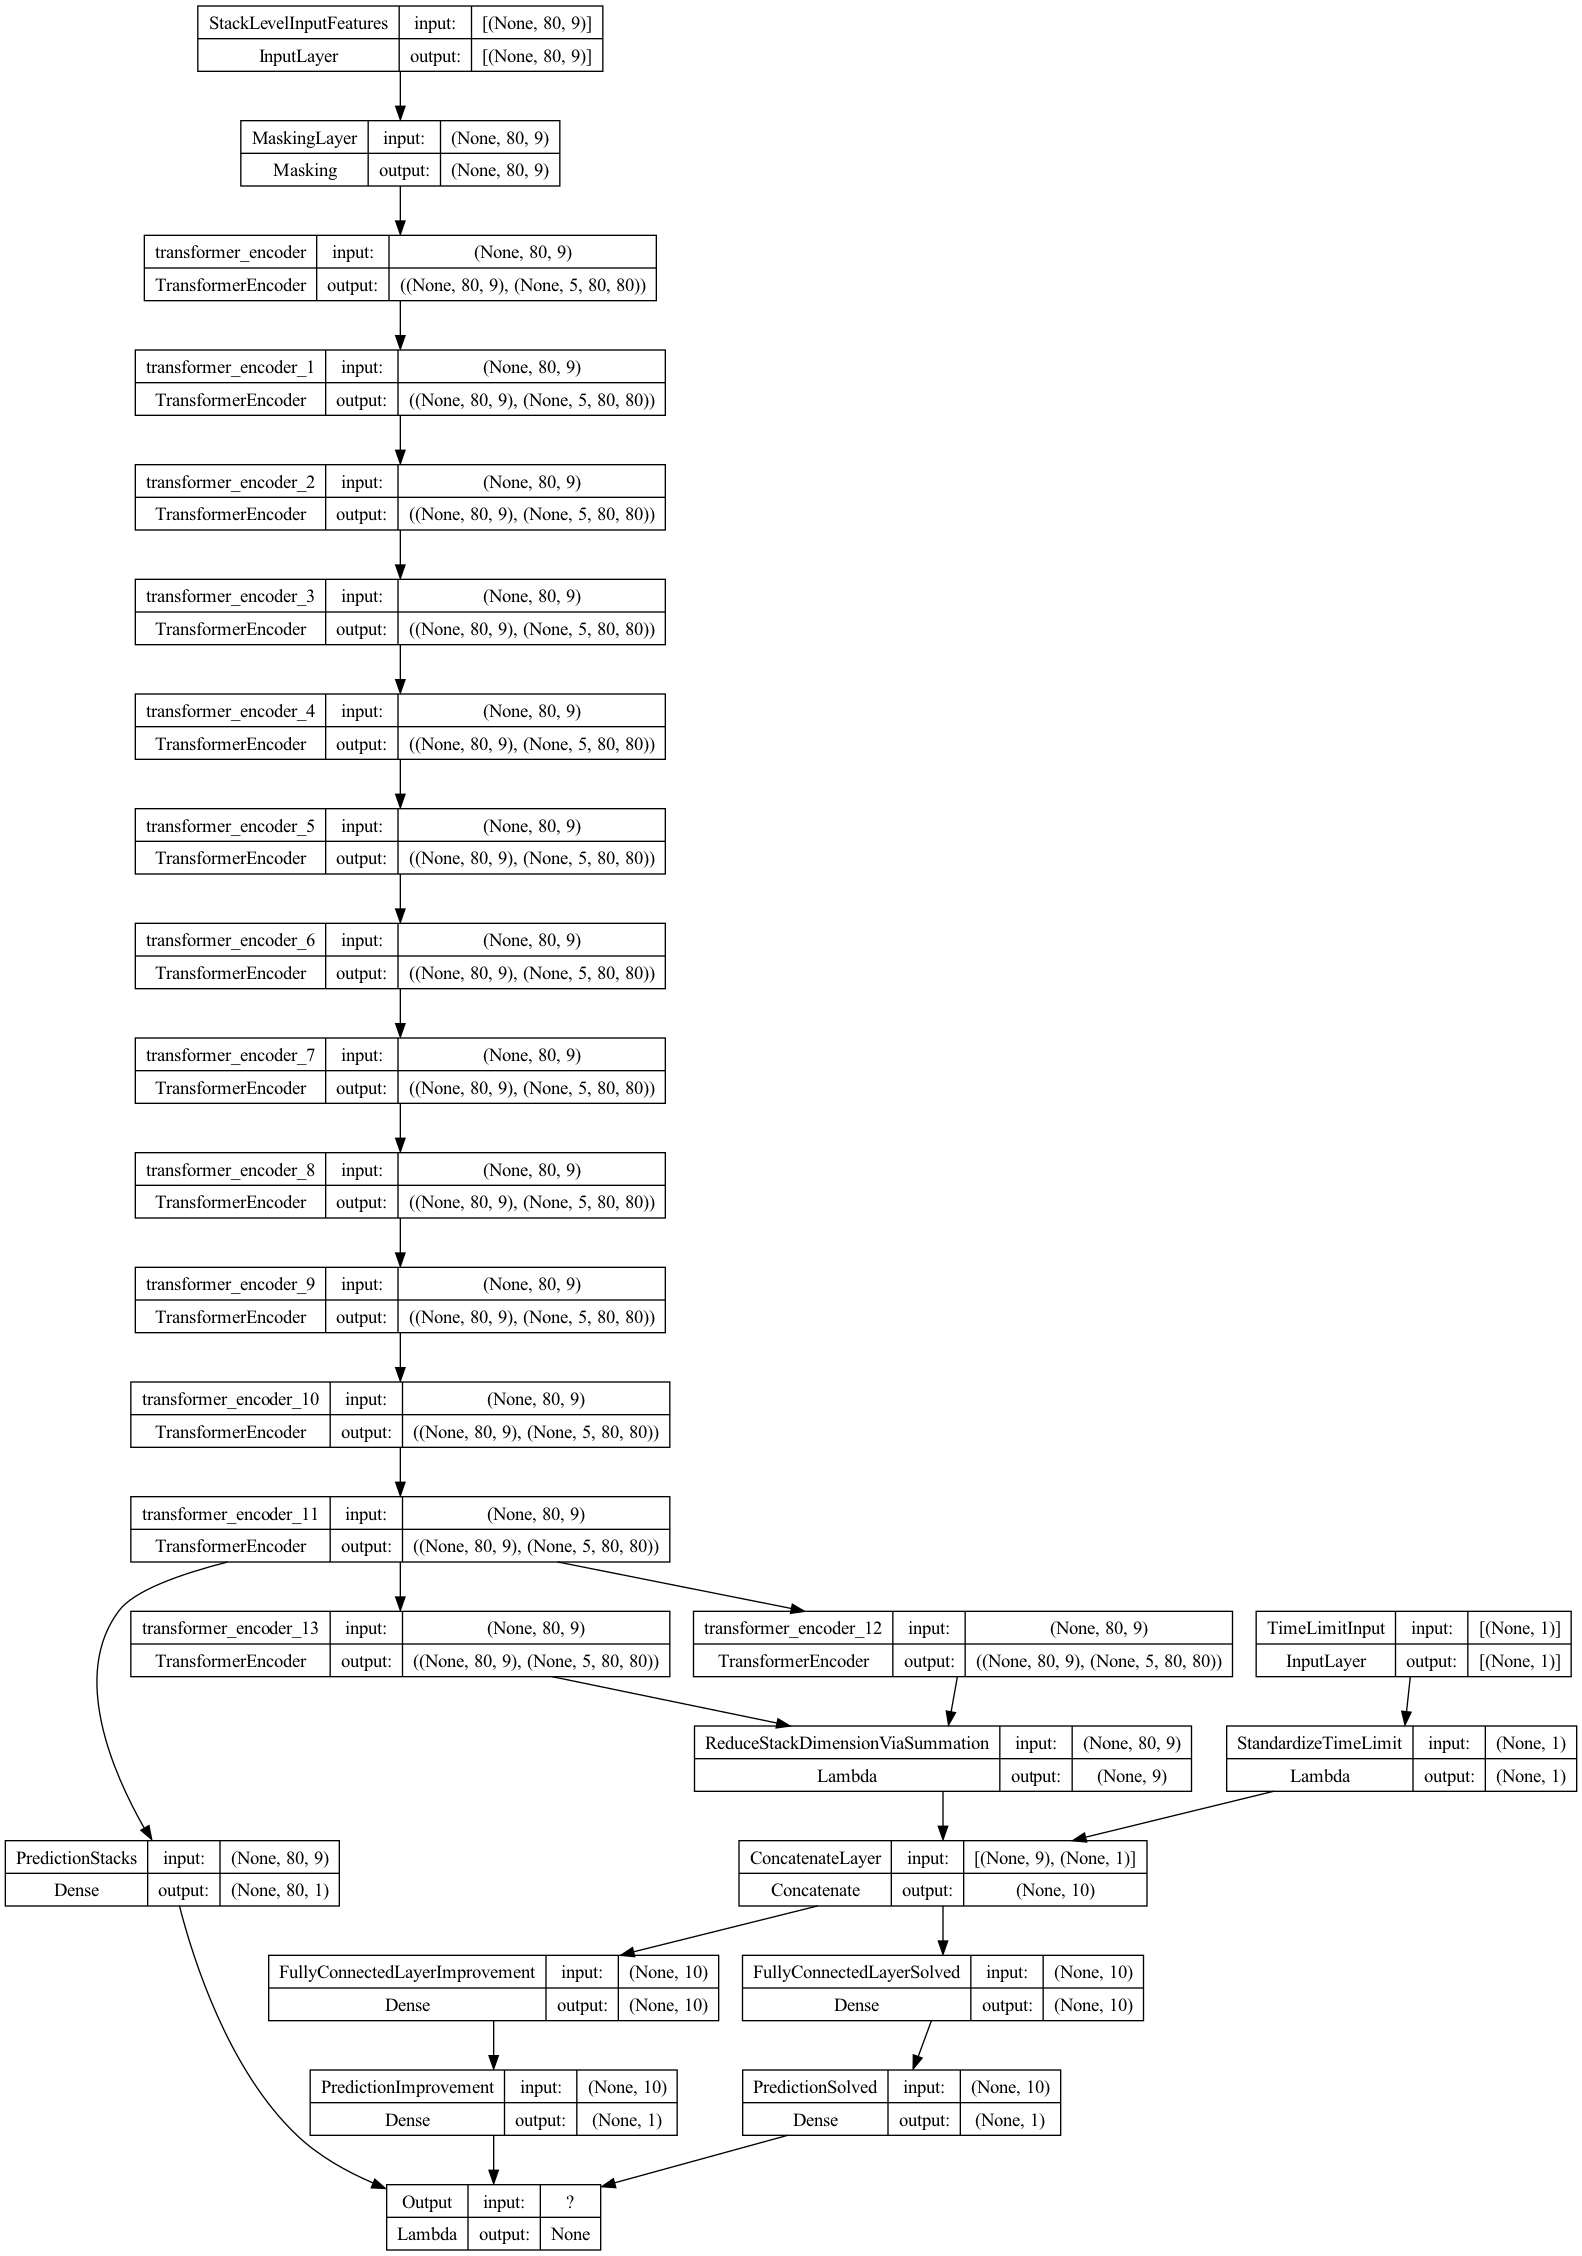

In [22]:
tf.keras.utils.plot_model(
    model,
    #to_file,
    show_shapes=True
)

## Training Process Functions

In [23]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [24]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [25]:
@tf.function
def model_pass(inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            mean_loss(losses[i])
        
    return outputs


In [26]:
def run_epoch(dataset, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, (X_batch, y_batch) in enumerate(dataset):
        
        X_batch, y_batch = polars_transformation(X_batch, y_batch, shuffle=shuffle)
        
        outputs = model_pass(X_batch, y_batch, training=training)
        #mean_loss(loss)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [TARGET_LABELS[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [TARGET_LABELS[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return history

## Model Training

In [27]:
clms = ["Epoch", "Target", "Metric", "Value"]
track = pd.DataFrame(columns = clms)

In [28]:
n_epochs = 10

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")

    track = run_epoch(train_dataset, all_metrics, epoch=epoch, history=track, training=True, shuffle=True)
    track = run_epoch(val_dataset, all_metrics, epoch=epoch, history=track, training=False, shuffle=True)

    # make an intermediate save of the model
    model_path = os.path.join(cwd, "models", f"EncoderUpdate-{epoch}.tf")
    model.save(model_path, overwrite=True, save_format="tf")

    print("-"*120)

Epoch 001/010


2023-12-03 18:02:03.839120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 625/625	LR: 0.007322906                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_92907/102180396.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 070/70 	LR: 0.007319244                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-1.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 002/010
Training-Iteration: 625/625	LR: 0.005357134                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-2.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-2.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 003/010
Training-Iteration: 625/625	LR: 0.003919056                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-3.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-3.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 004/010
Training-Iteration: 625/625	LR: 0.002867019                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-4.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-4.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 005/010
Training-Iteration: 625/625	LR: 0.002097392                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-5.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-5.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 006/010
Training-Iteration: 625/625	LR: 0.001534365                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-6.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-6.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 007/010
Training-Iteration: 625/625	LR: 0.001122477                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-7.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-7.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 008/010
Training-Iteration: 625/625	LR: 0.000821158                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-8.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-8.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 009/010
Training-Iteration: 625/625	LR: 0.000600725                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-9.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-9.tf/assets


------------------------------------------------------------------------------------------------------------------------
Epoch 010/010
Training-Iteration: 625/625	LR: 0.000439465                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-10.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/EncoderUpdate-10.tf/assets


------------------------------------------------------------------------------------------------------------------------


In [29]:
history = track\
    .pivot_table(
        values = ["Value"],
        columns=["Metric"],
        index=["Epoch", "Target"]
    )\
    .reset_index()\
    .set_index("Epoch", drop=True)

clms = history.columns
history.columns = [clm[i>=1] for i, clm in enumerate(clms)]
history

,Target,ACC,AUC,Loss,PRC,SNS,Val-ACC,Val-AUC,Val-Loss,Val-PRC,Val-SNS
Epoch,,,,,,,,,,,
1,Improvement,0.677786,0.711286,0.210699,0.655459,0.660731,0.717347,0.774608,0.202008,0.655934,0.823602
1,Solved,0.784906,0.824223,0.116667,0.787288,0.626156,0.731007,0.854161,0.138604,0.613841,0.863602
1,Stacks,0.973533,0.109048,0.011114,0.171931,0.163530,0.983790,0.307094,0.001244,0.504600,0.153084
2,Improvement,0.757696,0.825128,0.175121,0.744804,0.735806,0.772904,0.852528,0.164115,0.763915,0.739810
2,Solved,0.829994,0.881539,0.097559,0.846338,0.697435,0.837029,0.897872,0.095158,0.787584,0.805446
2,Stacks,0.981191,0.232920,0.001440,0.378626,0.240478,0.985434,0.402156,0.001101,0.673770,0.201476
3,Improvement,0.777853,0.857986,0.160012,0.767876,0.754821,0.789097,0.870976,0.155656,0.806827,0.717915
3,Solved,0.845132,0.899655,0.089896,0.861958,0.725159,0.841334,0.903852,0.090709,0.799502,0.799616
3,Stacks,0.981860,0.252625,0.001342,0.401031,0.229222,0.985290,0.378706,0.001059,0.634587,0.224141


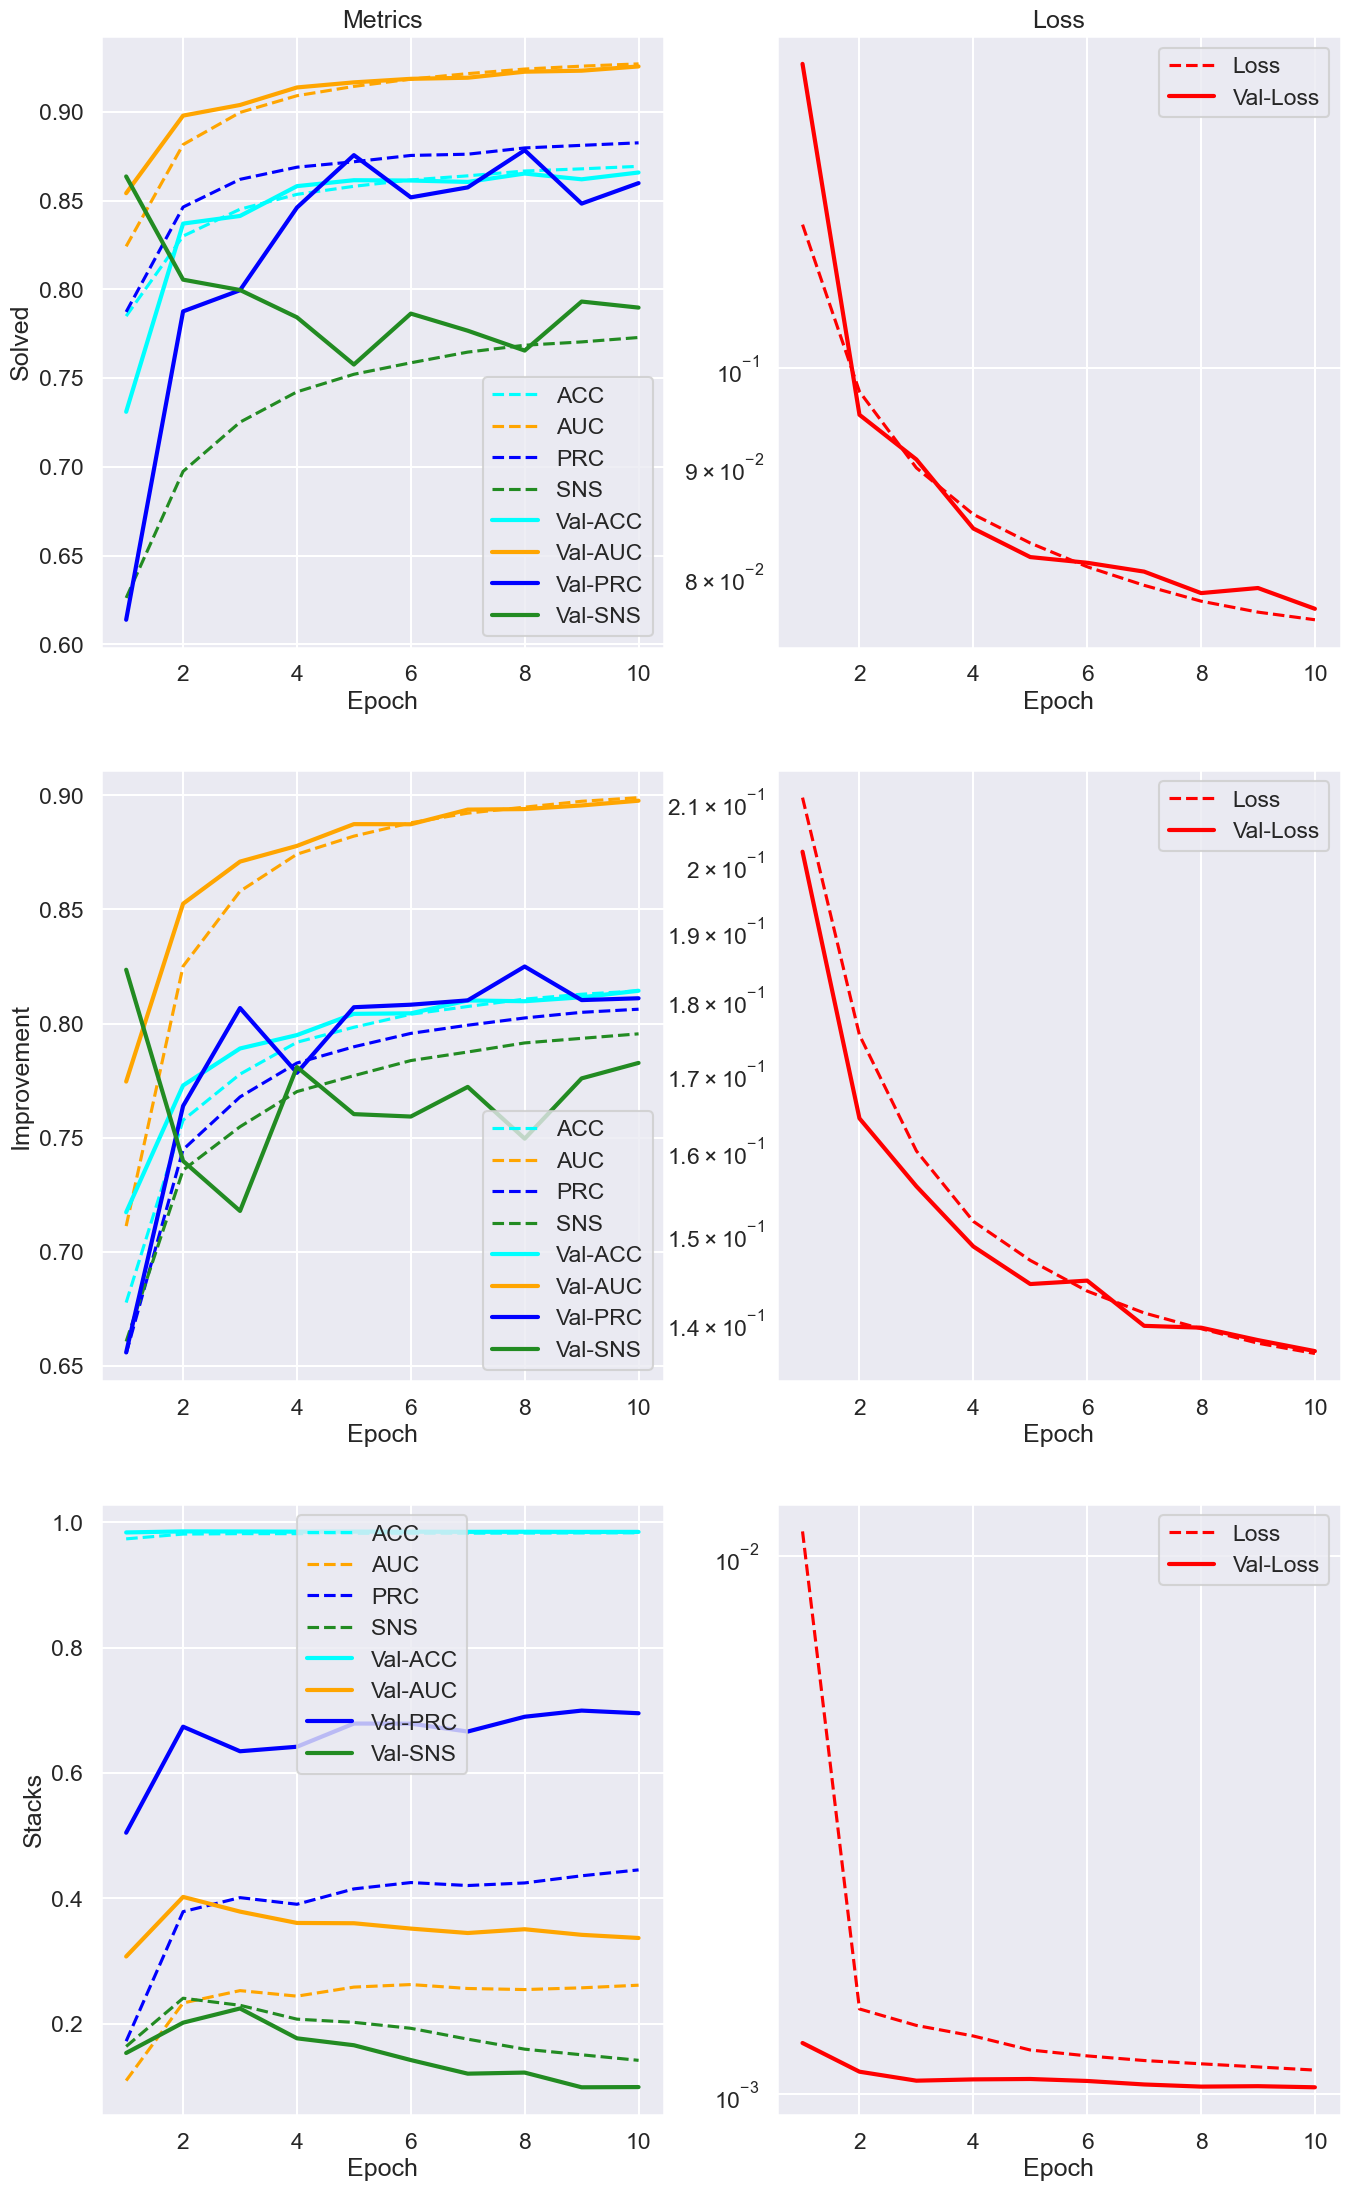

In [30]:
clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(16, 9*len(TARGET_LABELS)))

colors = ["cyan", "orange", "blue", "forestgreen", "red", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    # Plot the loss
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    ax[i, 1].set(yscale = "log")

ax[0, 0].set(title="Metrics")
ax[0, 1].set(title="Loss");


Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision

### Visualize Attention Scores:

In [31]:
from utils.DNN.utils import get_attention_scores

attention = get_attention_scores(model, model_inputs=cx, layer_name="transformer_encoder_5")
attention.shape
#cx[0][24].round(2)[:40]

(1024, 5, 80, 80)

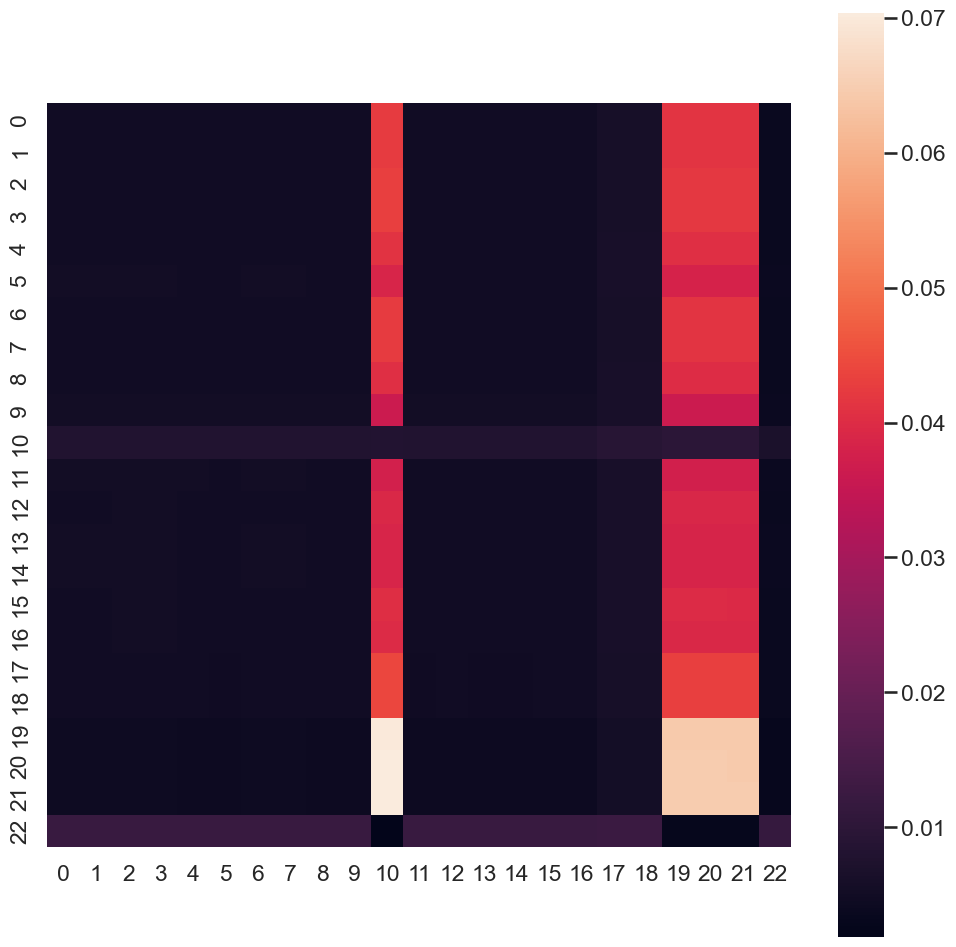

In [32]:
instance, head = 24, 3 # 18: 36 # 24 is a very simple but good example

attention_matrix = attention[instance, head, :, :]

# truncate:
n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
attention_matrix = attention_matrix[:n_inputs, :n_inputs]

plt.figure(figsize=(12, 12))
sns.heatmap(attention_matrix.T,
            square=True,
            #vmin=0, vmax=1
           );

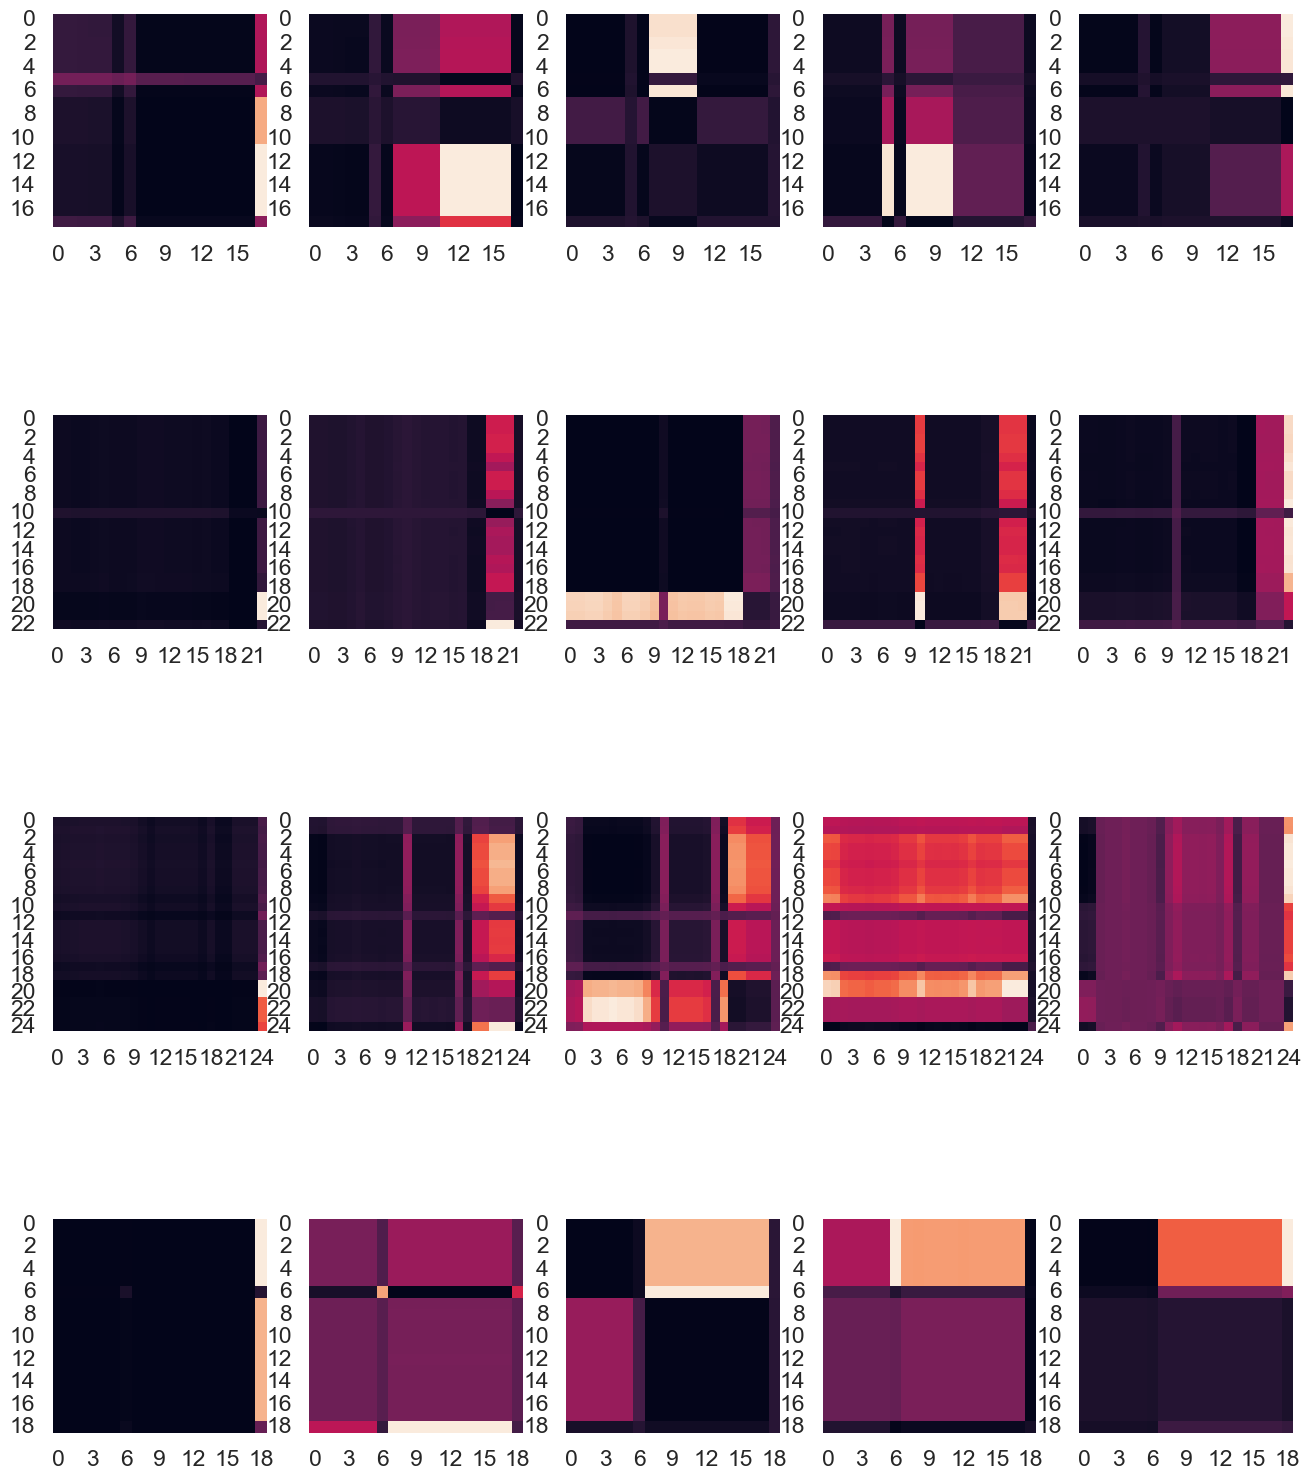

In [33]:
instances = [28, 24, 25, 26]
heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):

        # Truncate
        attention_matrix = attention[instance, head, :, :]
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            #vmin=0, vmax=0.1,
            ax=ax[i, h]
        );

# Load the model to see if it works

In [34]:
model_path = os.path.join(cwd, "models", f"EncoderUpdate-1.tf")

loaded_model = tf.keras.models.load_model(model_path)
loaded_model(cx)

[<tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0.5731004 , 0.4924468 , 0.6363791 , 0.8583745 , 0.45726097, 0.42946783, 0.2790385 , 0.3868872 , 0.5010623 , 0.26941952, 0.73199767, 0.7687545 , 0.50631773, 0.44419932, 0.89517075, 0.9532472 , 0.3702357 , 0.43608   , 0.93743587, 0.4787158 , 0.48167843, 0.52250946, 0.6156619 , 0.34230512, 0.4414192 , 0.4452104 , 0.23718043, 0.73367655, 0.50921786, 0.688812  , ..., 0.30067432, 0.7592861 , 0.3396541 , 0.47751516, 0.4467311 , 0.7110754 , 0.48462263, 0.33830526, 0.6590506 , 0.3171762 , 0.6358632 , 0.2507076 , 0.62053597, 0.9529729 , 0.720381  , 0.56893235, 0.9391322 , 0.4708638 , 0.5659748 , 0.705714  , 0.42711166, 0.36570013, 0.32657248, 0.7285234 , 0.539577  , 0.5887562 , 0.3568948 , 0.43508574, 0.7066218 , 0.53443843], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0.77053064, 0.35893655, 0.54392505, 0.10775093, 0.6232811 , 0.6850673 , 0.4386966 , 0.4853076 , 0.42832106, 0.56265026, 0.6994068 , 0.06918199, 0